# FCNN training

In [1]:
# This is only valid when the package is not installed
import sys
sys.path.append('../../') # two folders up
import DeepINN as dp
import torch

Using default backend: PyTorch
Using Pytorch:  2.0.1+cu117


## Geometry

In [2]:
# A simple 1D geometry
X = dp.spaces.R2('x')
Rect = dp.domains.Parallelogram(X, [0,0], [1,0], [0,1]) # unit square

In [3]:
left_bc = dp.constraint.DirichletBC(geom = Rect,
                                      function = lambda X: torch.tensor([0.0]),
                                      sampling_strategy = "grid",
                                      no_points = 10, 
                                      filter_fn = lambda x: x[:, 0] == 0.0)
right_bc = dp.constraint.DirichletBC(geom = Rect,
                                      function = lambda X: torch.tensor([1.0]),
                                      sampling_strategy = "grid",
                                      no_points = 10, # you can use more points. there are conditions to deal with stupid conditions. 
                                      filter_fn = lambda x: x[:, 0] == 1.0)

interior_points = dp.constraint.PDE(geom = Rect,
                                    sampling_strategy= "LatinHypercube",
                                    no_points = 30)

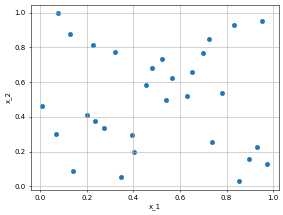

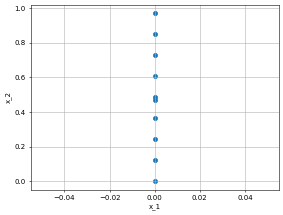

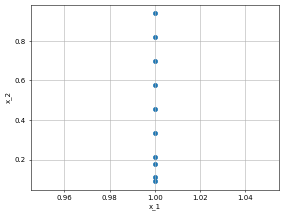

In [4]:
dp.utils.scatter(X, interior_points.sampler_object(), dpi = 50) # collocation points
dp.utils.scatter(X, left_bc.sampler_object(), dpi = 50)
dp.utils.scatter(X, right_bc.sampler_object(), dpi = 50)

## PDE

In [5]:
def laplace(X,y):
    """
    2D Laplace equation.
    u__x + u__y = 0
     i is always zero because output to the NN is always 1D
    """
    dy_x = dp.constraint.Jacobian(X, y)(i=0, j=0)
    dy_xx = dp.constraint.Jacobian(X, dy_x)(i = 0, j = 0)

    dy_y = dp.constraint.Jacobian(X, y)(i=0, j=1)
    dy_yy = dp.constraint.Jacobian(X, dy_y)(i = 0, j = 1)

    return dy_xx + dy_yy

In [6]:
domain = dp.domain.Generic(laplace,
                            interior_points,
                            [left_bc, right_bc])

## Network

In [7]:
activation = "tanh"
initialiser = "Xavier normal"
layer_size = [1] + [2] * 1 + [1]

In [8]:
net = dp.nn.FullyConnected(layer_size, activation, initialiser)
model = dp.Model(domain, net)

TypeError: __init__() missing 1 required positional argument: 'self'

In [ ]:
optimiser = "adam"
lr=0.001
metrics="MSE"

model.compile(optimiser, lr, metrics, device = "cuda")

Domain compiled
Network compiled


In [ ]:
model.optimiser_function, model.lr, model.metric

(torch.optim.adam.Adam, 0.001, MSELoss())

In [ ]:
model.train(iterations = 500)

TypeError: max(): argument 'input' (position 1) must be Tensor, not list

In [ ]:
# model.iter = 1
# model.train(iterations = 2000)

In [ ]:
model.network

FullyConnected(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [ ]:
coordinates_list = dp.utils.tensor2numpy([model.collocation_point_sample, model.boundary_point_sample])
solution_list = dp.utils.tensor2numpy([model.collocation_forward, model.BC_forward])

In [ ]:
history = model.training_history

In [ ]:
import matplotlib.pyplot as plt

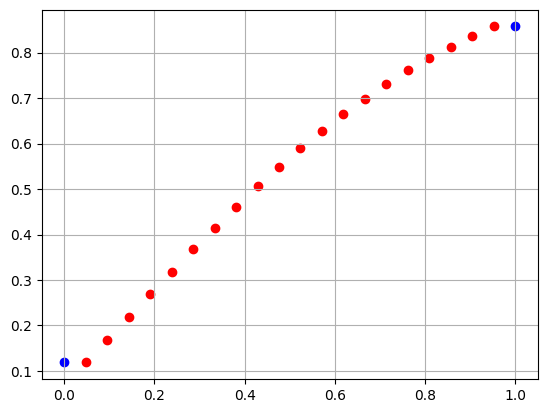

In [ ]:
plt.figure(1)
plt.scatter(coordinates_list[0], solution_list[0], label = "collocation points", color = "red")
plt.scatter(coordinates_list[1], solution_list[1], label = "boundary points", color = "blue")
plt.grid('minor')

Text(0, 0.5, 'Loss')

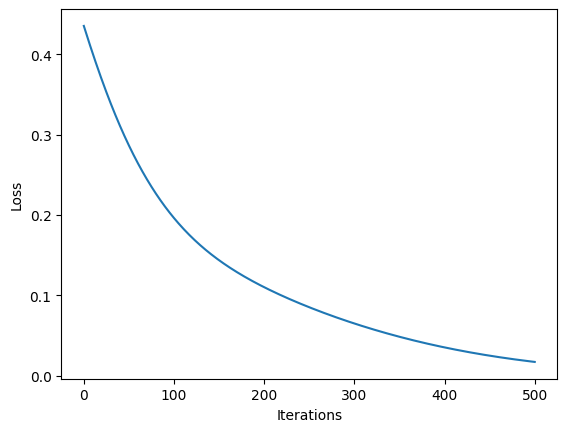

In [ ]:
plt.figure(2)
plt.plot(history)
plt.xlabel("Iterations")
plt.ylabel("Loss")